Encoder - 28*28 -> 256 -> 128 ->64 -> 16
Decoder 16 -> 64 -> 128 -> 256 -> 28*28
Perform the above operation for an autoencoder with the Dataset MNIST and print the loss graph and show the original image against the reconstructed image. User 5 epochs.

In [ ]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import time

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [ ]:
# Transforms images to a PyTorch Tensor
tensor_transform = transforms.ToTensor()

# Download the MNIST Dataset
dataset = datasets.MNIST(root="./data",
                         train=True,
                         download=True,
                         transform=tensor_transform)

# DataLoader to load the dataset
loader = torch.utils.data.DataLoader(dataset=dataset,
                                     batch_size=32,
                                     shuffle=True)


100%|██████████| 9.91M/9.91M [00:00<00:00, 36.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 3.90MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.7MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.76MB/s]


In [ ]:
class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder: 784 (28*28) -> 9
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(28 * 28, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 18),
            torch.nn.ReLU(),
            torch.nn.Linear(18, 9)
        )

        # Decoder: 9 -> 784 (28*28)
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(9, 18),
            torch.nn.ReLU(),
            torch.nn.Linear(18, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 28 * 28),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        start_encode = time.perf_counter()
        encoded = self.encoder(x)
        end_encode = time.perf_counter()
        encode_time = end_encode - start_encode

        start_decode = time.perf_counter()
        decoded = self.decoder(encoded)
        end_decode = time.perf_counter()
        decode_time = end_decode - start_decode

        return decoded, encode_time, decode_time


In [ ]:
# Initialize model, loss function, and optimizer
model = AE().to(device)
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [ ]:
epochs = 5
losses = []
total_encode_time = 0.0
total_decode_time = 0.0
total_batches = 0

for epoch in range(epochs):
    epoch_encode_time = 0.0
    epoch_decode_time = 0.0
    epoch_batches = 0

    for (image, _) in loader:
        image = image.reshape(-1, 28*28).to(device)

        reconstructed, encode_time, decode_time = model(image)

        epoch_encode_time += encode_time
        epoch_decode_time += decode_time
        total_encode_time += encode_time
        total_decode_time += decode_time
        epoch_batches += 1
        total_batches += 1

        loss = loss_function(reconstructed, image)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    avg_encode_time = epoch_encode_time / epoch_batches
    avg_decode_time = epoch_decode_time / epoch_batches
    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, '
          f'Avg Encode Time: {avg_encode_time*1000:.2f} ms, '
          f'Avg Decode Time: {avg_decode_time*1000:.2f} ms')

# Overall average times
avg_total_encode_time = total_encode_time / total_batches
avg_total_decode_time = total_decode_time / total_batches
print(f'\nOverall Average Encode Time: {avg_total_encode_time*1000:.2f} ms')
print(f'Overall Average Decode Time: {avg_total_decode_time*1000:.2f} ms')


Epoch 1/5, Loss: 0.0471, Avg Encode Time: 0.47 ms, Avg Decode Time: 0.41 ms
Epoch 2/5, Loss: 0.0394, Avg Encode Time: 0.49 ms, Avg Decode Time: 0.43 ms
Epoch 3/5, Loss: 0.0318, Avg Encode Time: 0.49 ms, Avg Decode Time: 0.43 ms
Epoch 4/5, Loss: 0.0297, Avg Encode Time: 0.50 ms, Avg Decode Time: 0.45 ms
Epoch 5/5, Loss: 0.0251, Avg Encode Time: 0.49 ms, Avg Decode Time: 0.43 ms

Overall Average Encode Time: 0.49 ms
Overall Average Decode Time: 0.43 ms


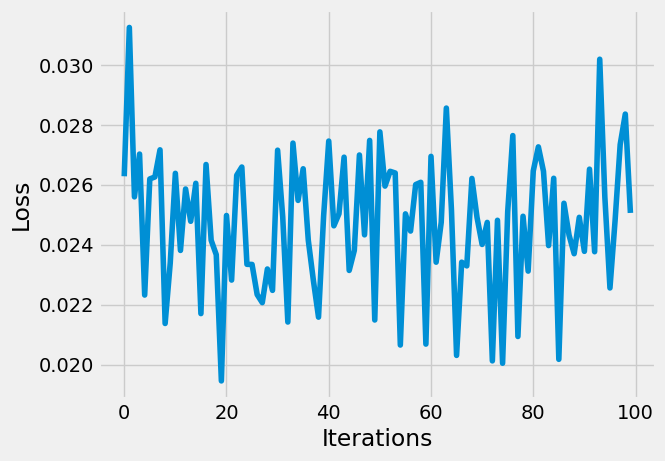

In [ ]:
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.plot(losses[-100:])
plt.show()



Inference Timing for Visualization Batch:
Encode Time: 0.50 ms
Decode Time: 0.34 ms
Total Inference Time: 0.87 ms


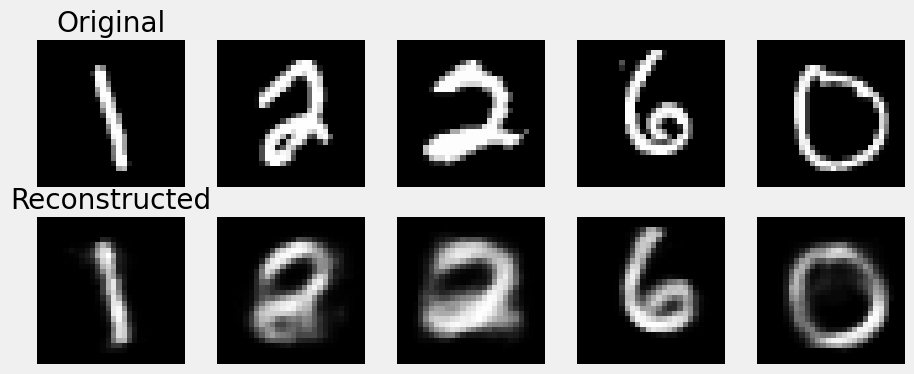

In [ ]:
with torch.no_grad():
    image, _ = next(iter(loader))
    image = image.reshape(-1, 28*28).to(device)

    start_encode = time.perf_counter()
    reconstructed, encode_time, decode_time = model(image)
    end_decode = time.perf_counter()

    print(f'\nInference Timing for Visualization Batch:')
    print(f'Encode Time: {encode_time*1000:.2f} ms')
    print(f'Decode Time: {decode_time*1000:.2f} ms')
    print(f'Total Inference Time: {(end_decode - start_encode)*1000:.2f} ms')

    image = image.cpu()
    reconstructed = reconstructed.cpu()

    plt.figure(figsize=(10, 4))
    for i in range(5):
        plt.subplot(2, 5, i + 1)
        plt.imshow(image[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title('Original')

        plt.subplot(2, 5, i + 6)
        plt.imshow(reconstructed[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title('Reconstructed')
    plt.show()
